In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math


In [3]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename, verbose=False): 
    if verbose:
        print(f'Loading file: {filename} ...')
    
    dcm = pydicom.dcmread(filename)       
    
    if verbose:
        print(dcm)
        print(f'ID: {dcm.PatientID}')
        print(f'Sex: {dcm.PatientSex}')
        print(f'Age: {dcm.PatientAge}')
        print(f'Modality: {dcm.Modality}')
        print(f'Study Description: {dcm.StudyDescription}')
        print(f'Rows: {dcm.Rows}')
        print(f'Columns: {dcm.Columns}')
        
    # Age
    age = int(dcm.PatientAge)
    if age < 2 or age > 90:
        print(f'Image {filename} rejected, Age: {age}')
        return None
    
    # Body Part
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Body part: {body_part}')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position: {pos}')
        return None
    
    # Modali
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'Image {filename} rejected, Modality: {mod}')
        return None
    
    return dcm.pixel_array
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_mean, img_std, img_size, verbose=False): 
    
    if verbose:
        print(f'Image data: {img.shape}')
    
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
        
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)

    if verbose:
        print(f'Resized data: {resized_img.shape}')

    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)

    if verbose:
        print(f'Processed data: {proc_img.shape}')

    return proc_img


# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)

    # load weights into new model
    model.load_weights(weight_path)
    print(f"Model loaded: {model}")
    
    return model


# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    
    pred = model.predict(img)
    prediction = pred > thresh
    
    # batch size: 1, single output
    return prediction[0][0]


def show_image_distr(img):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()


Loading file: test1.dcm ...
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROM

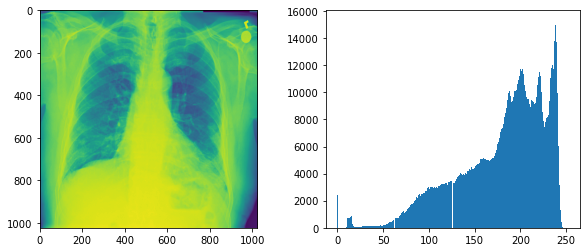

In [4]:
img_example = check_dicom('test1.dcm', verbose=True)
show_image_distr(img_example)

Image data: (1024, 1024)
Resized data: (224, 224)
Processed data: (1, 224, 224, 3)


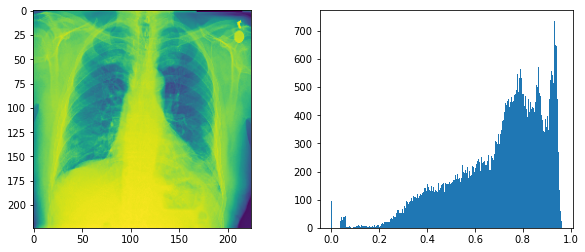

In [5]:
img_example_proc = preprocess_image(img_example, -1, -1, (1, 224, 224, 3), verbose=True)[0, :, :, 0]
show_image_distr(img_example_proc)

In [6]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'xray_final_model.json'
weight_path = 'xray_classification_model.best.hdf5'

# VGG16
IMG_SIZE=(1,224,224,3)  

# Mean & std passed from outside not used
# Resize function used in preprocessing normalizes the image data automatically 
img_mean = -1           
img_std = -1

my_model = load_model(model_path, weight_path) 
thresh = 0.3                                   

def predict_dicom(filename):
    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return None
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    return pred


Model loaded: <keras.engine.sequential.Sequential object at 0x7f1d37843790>


In [7]:
def show_image_pred(img, filename, pred):
    plt.imshow(img, cmap='gray')
    plt.title(f'{filename}, prediction: {pred}')
    plt.show()

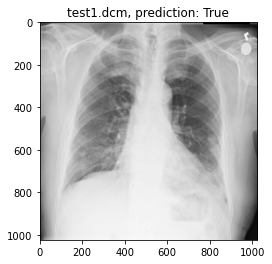

In [8]:
img_example_pred = predict_dicom('test1.dcm')
show_image_pred(img_example, 'test1.dcm', img_example_pred)

Image test4.dcm rejected, Body part: RIBCAGE
Image test5.dcm rejected, Modality: CT
Image test6.dcm rejected, Patient position: XX


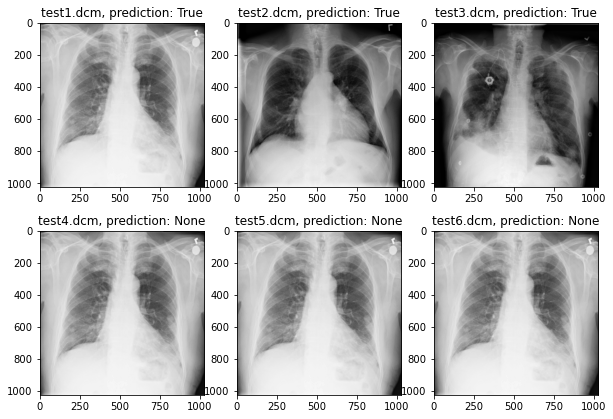

In [9]:
# use the .dcm files to test your prediction

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
    
for i,filename in enumerate(test_dicoms):
    pred = predict_dicom(filename)
    
    img = pydicom.dcmread(filename).pixel_array        
    
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')

plt.show()    
    

# Appendix A. Analysis of model's preformance

A more detailed analysis than in the 'build model' notebook. Here we will also take into account such metrics as PPV and NPV, and see how model performs in the presence of other conditions.

In [10]:
valid = pd.read_csv('pneumonia_valid.csv')
valid

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Cardiomegaly,Hernia,Mass,Consolidation,Atelectasis,Pneumonia,Fibrosis,Nodule,Emphysema,pneumonia_class
0,00011237_067.png,Infiltration|Pneumonia,67,11237,56,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Y
1,00021201_053.png,Atelectasis|Edema|Effusion|Pneumonia,53,21201,66,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Y
2,00012993_014.png,Edema|Infiltration|Pneumonia,14,12993,34,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Y
3,00009925_037.png,Effusion|Infiltration|Pneumonia,37,9925,57,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Y
4,00007191_001.png,Pneumonia,1,7191,28,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,00026500_000.png,No Finding,0,26500,55,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1426,00010505_013.png,No Finding,13,10505,46,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1427,00006585_005.png,No Finding,5,6585,16,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1428,00017786_003.png,No Finding,3,17786,50,M,PA,2530,2361,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [11]:
def predict_image_prob(model, img): 
    return model.predict(img)[0][0]


def predict_valid(row):
    ind = row.name
    path = row['path']
    
    s = time()
    img_data = image.imread(path)
    img_prep = preprocess_image(img_data, -1, -1, IMG_SIZE, verbose=False)
    time_load = int((time() - s)*1000000)
    
    s = time()
    result = predict_image_prob(my_model, img_prep)
    time_predict = int((time() - s)*1000000)

    if int(ind) % 100 == 0:
        print(f'[{ind}] Processed {path}, result: {result :.5f}', flush=True)

    return pd.Series([result, time_load, time_predict])

In [12]:
valid[['pneumonia_pred', 'time_load', 'time_pred']] = valid.apply(lambda x: predict_valid(x), axis=1)

[0] Processed /data/images_005/images/00011237_067.png, result: 0.48085
[0] Processed /data/images_005/images/00011237_067.png, result: 0.48085
[100] Processed /data/images_005/images/00010693_012.png, result: 0.35004
[200] Processed /data/images_009/images/00019880_007.png, result: 0.38994
[300] Processed /data/images_003/images/00004425_001.png, result: 0.18481
[400] Processed /data/images_009/images/00020408_020.png, result: 0.60656
[500] Processed /data/images_011/images/00026546_006.png, result: 0.49170
[600] Processed /data/images_010/images/00022713_004.png, result: 0.24871
[700] Processed /data/images_008/images/00016415_000.png, result: 0.36090
[800] Processed /data/images_009/images/00020642_006.png, result: 0.31729
[900] Processed /data/images_002/images/00002474_003.png, result: 0.70102
[1000] Processed /data/images_003/images/00006394_000.png, result: 0.41639
[1100] Processed /data/images_008/images/00016191_015.png, result: 0.46297
[1200] Processed /data/images_007/images

In [13]:
valid.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Consolidation,Atelectasis,Pneumonia,Fibrosis,Nodule,Emphysema,pneumonia_class,pneumonia_pred,time_load,time_pred
0,00011237_067.png,Infiltration|Pneumonia,67,11237,56,F,AP,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,Y,0.480853,25647.0,533782.0
1,00021201_053.png,Atelectasis|Edema|Effusion|Pneumonia,53,21201,66,M,AP,3056,2544,0.139,...,0.0,1.0,1.0,0.0,0.0,0.0,Y,0.667808,88928.0,536919.0
2,00012993_014.png,Edema|Infiltration|Pneumonia,14,12993,34,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,Y,0.555758,44288.0,541204.0


In [14]:
y = valid.Pneumonia
y_pred = valid.pneumonia_pred

In [15]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()
    
def calc_f1(prec,recall):
    f1score = 2*(prec*recall)/(prec+recall)
    if not math.isnan(f1score):
        return f1score
    else: 
        return 0

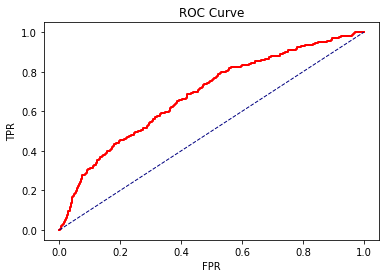

In [16]:
plot_auc(y, y_pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


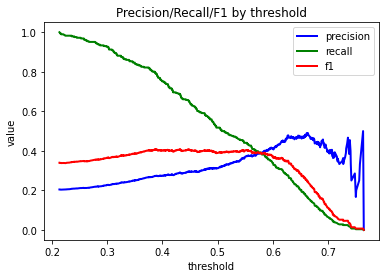

In [17]:
precision, recall, thresholds = precision_recall_curve(y, y_pred, pos_label=1)
f1scores = [calc_f1(precision[i], recall[i]) for i in range(len(thresholds))]

plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, color='red', lw=2, label='f1')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall/F1 by threshold')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


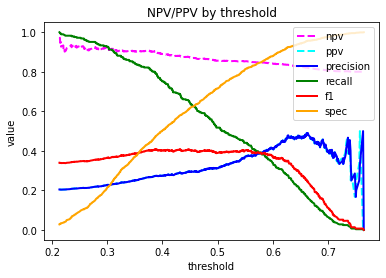

In [18]:
npv = []
ppv = []
spec = []

for th in thresholds:
    tn, fp, fn, tp = confusion_matrix(y, (y_pred > th).astype(int)).ravel()
    npv.append(tn / (tn + fn))
    ppv.append(tp / (tp + fp))
    spec.append(tn / (tn + fp))

plt.plot(thresholds, npv, color='magenta', lw=2, label='npv', linestyle='--')
plt.plot(thresholds, ppv, color='cyan', lw=2, label='ppv', linestyle='--')
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, color='red', lw=2, label='f1')
plt.plot(thresholds, spec, color='orange', lw=2, label='spec')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('NPV/PPV by threshold')
plt.show()

#### Initial summary from the metrics above

* Algoriths does not have high positive predictive value (unless recall drops to extremely low values), therefore it might not be a good idea to use this algorithm for detecting pneumonia
* Algorithm does maintain high recall without losing much in precision, therefore this algorithm can be useful for its negative predictive value and high recall. I.e. if an algorithm predicts negative, this can truly be negative with comparatively high probability (which can help de-prioritize such cases and save radiologist's time)

##### So, lets find appropriate threshold

In [19]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}, specificity: {spec[ind] :.3f}')

Max F1 score: 0.408, threshold: 0.431, precision: 0.290, recall: 0.689, specificity: 0.579


##### Lets see if we can find much higher recall without significant loss in F1 score

In [20]:
for i in range(200,1000,50):
    ind = np.argmax(np.array(f1scores[:i], dtype=np.float32))
    f1 = f1scores[ind]
    print(f'[{ind}] F1: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}, specificity: {spec[ind] :.3f}, npv: {npv[ind] :.3f}')

[199] F1: 0.360, threshold: 0.292, precision: 0.223, recall: 0.934, specificity: 0.186, npv: 0.918
[237] F1: 0.366, threshold: 0.301, precision: 0.228, recall: 0.927, specificity: 0.217, npv: 0.919
[279] F1: 0.370, threshold: 0.310, precision: 0.232, recall: 0.909, specificity: 0.249, npv: 0.913
[347] F1: 0.377, threshold: 0.325, precision: 0.240, recall: 0.881, specificity: 0.302, npv: 0.908
[396] F1: 0.382, threshold: 0.340, precision: 0.246, recall: 0.860, specificity: 0.339, npv: 0.904
[434] F1: 0.387, threshold: 0.350, precision: 0.251, recall: 0.846, specificity: 0.369, npv: 0.904
[495] F1: 0.397, threshold: 0.366, precision: 0.261, recall: 0.825, specificity: 0.417, npv: 0.903
[525] F1: 0.404, threshold: 0.377, precision: 0.268, recall: 0.818, specificity: 0.441, npv: 0.905
[574] F1: 0.407, threshold: 0.389, precision: 0.274, recall: 0.790, specificity: 0.477, npv: 0.900
[574] F1: 0.407, threshold: 0.389, precision: 0.274, recall: 0.790, specificity: 0.477, npv: 0.900
[574] F1: 

In [21]:
thresholds[525]

0.3767338693141937

##### Suggested threshold: 0.377

Comparing selected theshold 0.377 value with the one of maximum F1 score, we see that:

* F1 score goes from 0.408 to 0.404
* Precision goes from 0.290 to 0.268
* Recall goes from 0.689 to 0.818
* Specificity from 0.579 to 0.441

This is significant improvement in recall with comparatively small loss in precision and F1 score. The negative predictive value for this threshold is 0.905. This means that when our model predicts negative, it is right with 90.5% probability. At the same time it classifies correctly 44.1% of all negative cases and 81.8% of positive cases.

These numbers are achieved at the cost of lower precision (0.268), i.e. 73.2% probability that a positive prediction is a false positive. Still, the model has some positive predictive value, as it has 26.6% probability of being right when predicting positive.

#### Save validation set with predictions for future use 

In [22]:
valid.to_csv('pneumonia_valid_pred.csv', index=False)

In [23]:
!ls -la | grep pneumonia_valid

-rw-r--r-- 1 root root    264985 May 27 16:52 pneumonia_valid.csv
-rw-r--r-- 1 root root    315610 May 30 05:26 pneumonia_valid_pred.csv


### Model preformance with other conditions

In [24]:
valid['pneumonia_pred_th'] = valid.apply(lambda x: int(x['pneumonia_pred'] > thresholds[525]), axis=1)
valid.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Atelectasis,Pneumonia,Fibrosis,Nodule,Emphysema,pneumonia_class,pneumonia_pred,time_load,time_pred,pneumonia_pred_th
0,00011237_067.png,Infiltration|Pneumonia,67,11237,56,F,AP,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,Y,0.480853,25647.0,533782.0,1
1,00021201_053.png,Atelectasis|Edema|Effusion|Pneumonia,53,21201,66,M,AP,3056,2544,0.139,...,1.0,1.0,0.0,0.0,0.0,Y,0.667808,88928.0,536919.0,1
2,00012993_014.png,Edema|Infiltration|Pneumonia,14,12993,34,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,Y,0.555758,44288.0,541204.0,1


In [26]:
findings = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']
for i in findings:
    tn, fp, fn, tp = confusion_matrix(
        valid[valid[i]==1].Pneumonia.values,
        valid[valid[i]==1].pneumonia_pred_th.values,labels=[1,0]).ravel()
    
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    npvl = tn/(tn+fn)

    print(f'{i}: \nSensitivity (recall): {sens :.3f}, Specificity: {spec :.3f}, NPV: {npvl :.3f} \n')


Atelectasis: 
Sensitivity (recall): 0.301, Specificity: 0.760, NPV: 0.325 

Cardiomegaly: 
Sensitivity (recall): 0.296, Specificity: 0.889, NPV: 0.296 

Consolidation: 
Sensitivity (recall): 0.075, Specificity: 0.950, NPV: 0.339 

Edema: 
Sensitivity (recall): 0.125, Specificity: 0.987, NPV: 0.841 

Effusion: 
Sensitivity (recall): 0.154, Specificity: 0.900, NPV: 0.263 

Emphysema: 
Sensitivity (recall): 0.360, Specificity: 0.833, NPV: 0.238 

Fibrosis: 
Sensitivity (recall): 0.500, Specificity: 0.667, NPV: 0.222 

Hernia: 
Sensitivity (recall): 0.000, Specificity: 1.000, NPV: 0.333 

Infiltration: 
Sensitivity (recall): 0.289, Specificity: 0.914, NPV: 0.455 

Mass: 
Sensitivity (recall): 0.377, Specificity: 0.857, NPV: 0.240 

Nodule: 
Sensitivity (recall): 0.382, Specificity: 0.647, NPV: 0.208 

Pleural_Thickening: 
Sensitivity (recall): 0.500, Specificity: 0.714, NPV: 0.333 

Pneumothorax: 
Sensitivity (recall): 0.250, Specificity: 1.000, NPV: 0.150 



##### Summary concerning model use on patients with other conditions

* The model's sensitivity (recall) and negative predictive value, that are generally high, are lower when other conditions are present. They are extremely low with some conditions.

* It is not recommended to use the model with the following conditions (where recall is shown to drop to very low values): 
    * Consolidation: 0.075
    * Edema: 0.125
    * Effusion: 0.154
    * Hernia: 0.000
   

### Image preprocess & model inference time

In [27]:
valid[['time_load', 'time_pred']].describe()

,time_load,time_pred
count,1430.000000,1430.000000
mean,31702.858741,542255.125175
std,4347.903292,11686.507783
min,23838.000000,528179.000000
25%,29155.000000,535230.000000
50%,30895.000000,538368.000000
75%,33016.750000,546068.000000
max,88928.000000,626325.000000


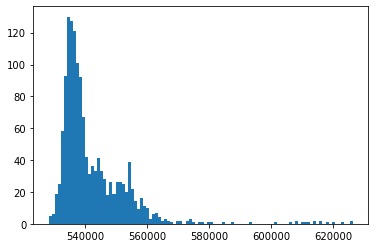

In [28]:
plt.hist(valid['time_pred'], bins=100)
plt.show()

**On Intel(R) Xeon(R) CPU @ 2.30GHz**:

* Average image pre-processing time: 32 ms, max: 89 ms
* Average inference time: 542 milliseconds, max: 626 ms